## Load Embeddings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [3]:
MODEL_DIR = '/Users/jax/code/labelrec/output/model_bceloss_labelart_negsamp=5_n=10'
LABEL_FILE = '/Users/jax/code/labelrec/data/csv/label.csv'
ARTIST_FILE = '/Users/jax/code/labelrec/data/csv/release_artist.csv'

In [4]:
state_dict = torch.load(f'{MODEL_DIR}/embedding.model')

In [5]:
art_emb, lab_emb = state_dict['art_embed.weight'].numpy(), state_dict['lab_embed.weight'].numpy()

In [6]:
with open(f'{MODEL_DIR}/art_emb_idx_inv.json', 'r') as fh:
    art_emb_idx_to_id = json.load(fh)
    art_emb_idx_to_id = {int(k): v for k, v in art_emb_idx_to_id.items()}
    art_emb_id_to_idx = {v: k for k, v in art_emb_idx_to_id.items()}

In [7]:
with open(f'{MODEL_DIR}/lab_emb_idx_inv.json', 'r') as fh:
    lab_emb_idx_to_id = json.load(fh)
    lab_emb_idx_to_id = {int(k): v for k, v in lab_emb_idx_to_id.items()}
    lab_emb_id_to_idx = {v: k for k, v in lab_emb_idx_to_id.items()}

In [8]:
lab_df = pd.read_csv(LABEL_FILE, usecols=['id', 'name'])
lab_df['name'] = lab_df['name'].str.lower()
lab_df = lab_df.set_index(['id'])

In [9]:
assert lab_emb.shape[0] == len(lab_emb_idx_to_id), 'lab dict isnt valid'

In [10]:
art_df = pd.read_csv(ARTIST_FILE, usecols=['artist_id', 'artist_name'])
art_df['artist_name'] = art_df['artist_name'].str.lower()
art_df = (
    art_df
    .groupby(['artist_id', 'artist_name'])
    .size()
    .rename('n')
    .reset_index()
    .set_index(['artist_id'])
)

In [11]:
assert art_emb.shape[0] == len(art_emb_idx_to_id), 'art dict isnt valid'

## Query Similar Artist

In [12]:
ARTIST_NAME = 'Seb Wildblood'
TOPN = 10

In [13]:
row = (
    art_df
    .loc[lambda df: df['artist_name'] == ARTIST_NAME.lower()]
)

In [14]:
if len(row) == 0:
    raise RuntimeError(f'Artist {ARTIST_NAME} was not found')
else:
    artist_id = row.index.tolist()[0]

In [15]:
art_emb_idx = art_emb_id_to_idx[artist_id]

In [16]:
norms = np.linalg.norm(art_emb - art_emb[art_emb_idx:art_emb_idx+1], axis=1)
sim_art_idxs = np.argsort(norms)

In [17]:
art_df.loc[[art_emb_idx_to_id[i] for i in sim_art_idxs[:TOPN]]]

,artist_name,n
artist_id,,
3038043,seb wildblood,32
5646528,pacific coliseum,12
293606,hobie,2
3038042,apes (5),5
621686,dan tuf,7
5303435,dj heure,9
3317911,tippy toes,3
1620394,name in lights,7
422521,d.b. hazard,4


## Query Similar Artist

In [18]:
LABEL_NAME = 'All My Thoughts'
TOPN = 10

In [19]:
row = (
    lab_df
    .loc[lambda df: df['name'] == LABEL_NAME.lower()]
)

In [20]:
if len(row) == 0:
    raise RuntimeError(f'Label {LABEL_NAME} was not found')
else:
    lab_id = row.index.tolist()[0]

In [21]:
lab_emb_idx = lab_emb_id_to_idx[lab_id]

In [22]:
norms = np.linalg.norm(lab_emb - lab_emb[lab_emb_idx:lab_emb_idx+1], axis=1)
sim_lab_idxs = np.argsort(norms)

In [23]:
lab_df.loc[[lab_emb_idx_to_id[i] for i in sim_lab_idxs[:TOPN]]]

,name
id,
1172610,all my thoughts
1064006,sw (2)
1509448,not on label (seb wildblood self-released)
657167,amber entertainment
834665,knife ritual
713498,division two records
206716,not on label (nightlife unlimited)
496574,iff wreckords detroit
88082,pump-kin records (2)


<Axes: >

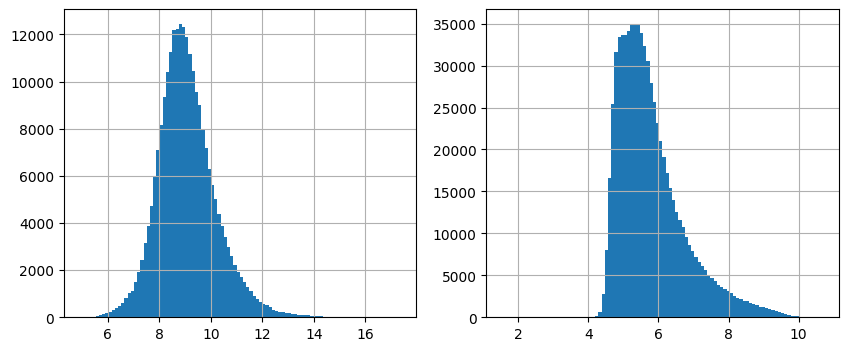

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

pd.Series(np.linalg.norm(lab_emb, axis=1), name='labels').hist(bins=100, ax=axs[0])
pd.Series(np.linalg.norm(art_emb, axis=1), name='artist').hist(bins=100, ax=axs[1])